In [1]:
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from textblob import TextBlob
from sklearn.metrics import roc_curve, auc

In [2]:
# Load dataset with proper encoding
file_path = 'C:/Users/user/Desktop/SALFORD 2/tgb_chronological.csv'
with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
    raw_data = file.read()


In [3]:
# Data Cleaning
entries = raw_data.split('\n\n')
data = []

for entry in entries:
    lines = entry.strip().split('\n')
    if len(lines) > 1:
        title = lines[1] if re.match(r'^\S+', lines[1]) else None
        content = " ".join(lines[2:])
        data.append({'title': title, 'content': content})

In [4]:
# Convert to DataFrame
blogpost = pd.DataFrame(data)

In [5]:
# Dropping empty entries
blogpost.dropna(subset=['content'], inplace=True)

# Exploratory Data Analysis

In [6]:
print(blogpost.head())

                                               title  \
0  EDITOR'S NOTE: This was originally published o...   
1  ",Debbie,"Thanks for taking the pressure off. ...   
2  ",starglitter,"I'm 29 and I'm really terrified...   
3                                                  "   
4                       ",suzi,"very informal.......   

                                             content  
0   I posted this on my fotolog today about turni...  
1  ",robin,"A friend of mine--a friend of a frien...  
2  ",u4eah,"You are so right!  Culture versus rea...  
3  http://www.timegoesby.net/weblog/2004/03/bill_...  
4  " http://www.timegoesby.net/weblog/2004/03/hap...  


# Word Cloud

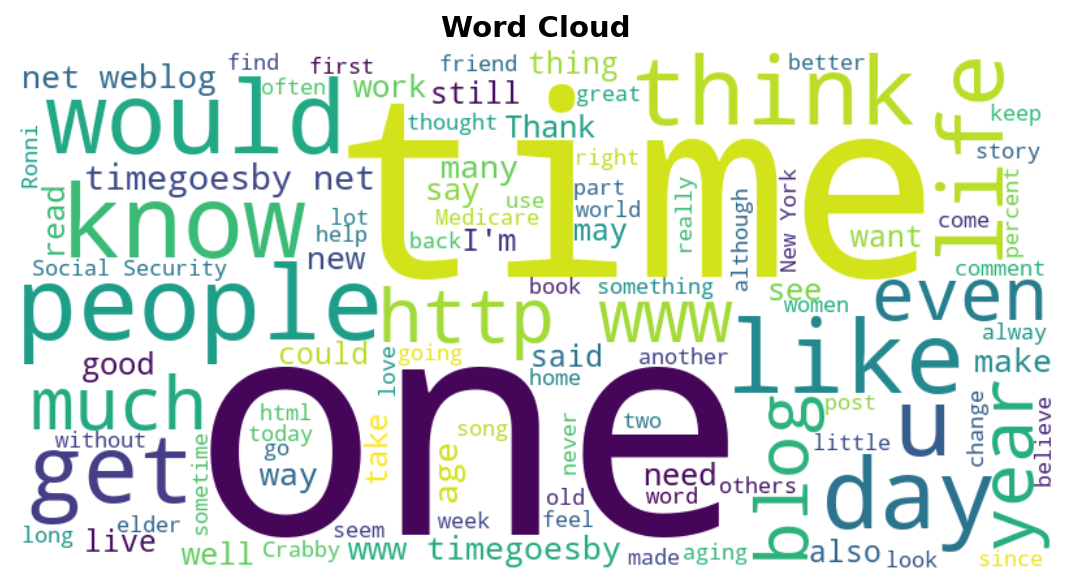

In [8]:
all_text = " ".join(blogpost['content'].dropna())

wordcloud = WordCloud(
    stopwords=set(stopwords.words('english')), 
    background_color='white', 
    max_words=100,         
    width=800,                
    height=400              
).generate(all_text)

# Creating a clearer visualization
plt.figure(figsize=(8, 4), dpi=150) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off')
plt.title('Word Cloud', fontsize=14, fontweight='bold') 
plt.tight_layout() 
plt.savefig('C:/Users/user/Desktop/SALFORD 2/wordcloud1.png')
plt.show()


# Tokenization and Stopwords Removal

### Preprocessing

In [9]:
stop_words = set(stopwords.words('english'))
blogpost['processed_content'] = blogpost['content'].apply(lambda x: " ".join(
    [word for word in word_tokenize(x.lower()) if word.isalpha() and word not in stop_words]))

### Sentiment Analysis

In [10]:
blogpost['sentiment'] = blogpost['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

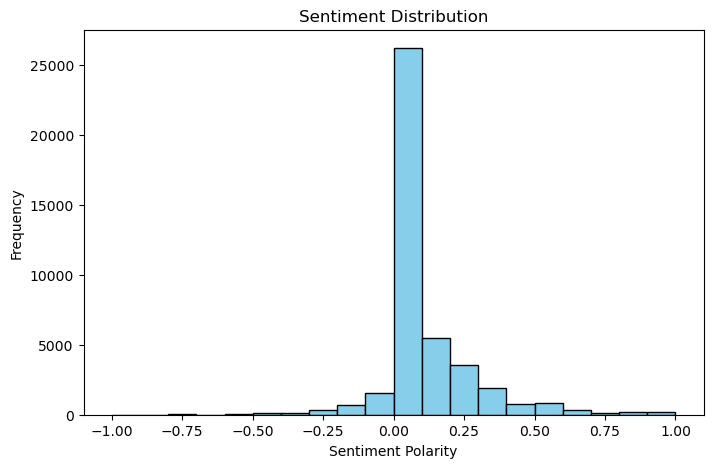

In [11]:
# Visualize Sentiment Distribution
plt.figure(figsize=(8, 5))
plt.hist(blogpost['sentiment'], bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.savefig('C:/Users/user/Desktop/SALFORD 2/Sentiment Distribution.png')
plt.show()

# Text Classification using Naive Bayes

In [12]:
blogpost['label'] = (blogpost['sentiment'] > 0).astype(int)

In [13]:
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(blogpost['processed_content']).toarray()
y = blogpost['label']

In [14]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [15]:
# Model Training
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [16]:
# Predictions
y_pred = model.predict(X_test)

In [17]:
# Evaluation
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88      7395
           1       0.93      0.71      0.80      5339

    accuracy                           0.85     12734
   macro avg       0.87      0.83      0.84     12734
weighted avg       0.86      0.85      0.85     12734



In [18]:
#Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[7101  294]
 [1572 3767]]


In [19]:
# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 85.35%


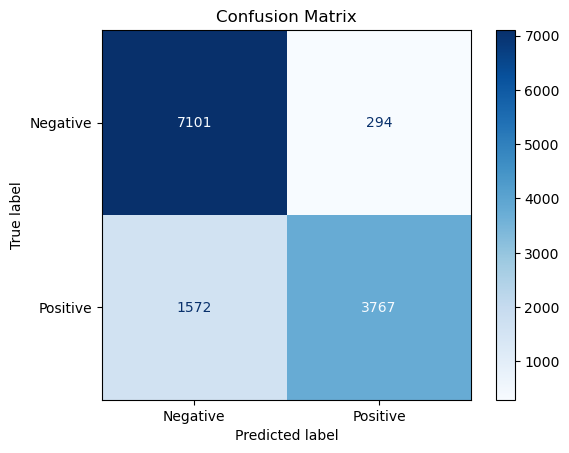

In [20]:
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Negative", "Positive"], cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig('C:/Users/user/Desktop/SALFORD 2/confusion matrix.png')
plt.show()

### Feature Importance (Word Contributions)

In [21]:
# Extract feature importance from Naive Bayes
feature_names = vectorizer.get_feature_names_out()
feature_prob = model.feature_log_prob_[1] - model.feature_log_prob_[0]

In [22]:
# Top 20 positive and negative words
top_positive_indices = feature_prob.argsort()[-20:][::-1]
top_negative_indices = feature_prob.argsort()[:20]

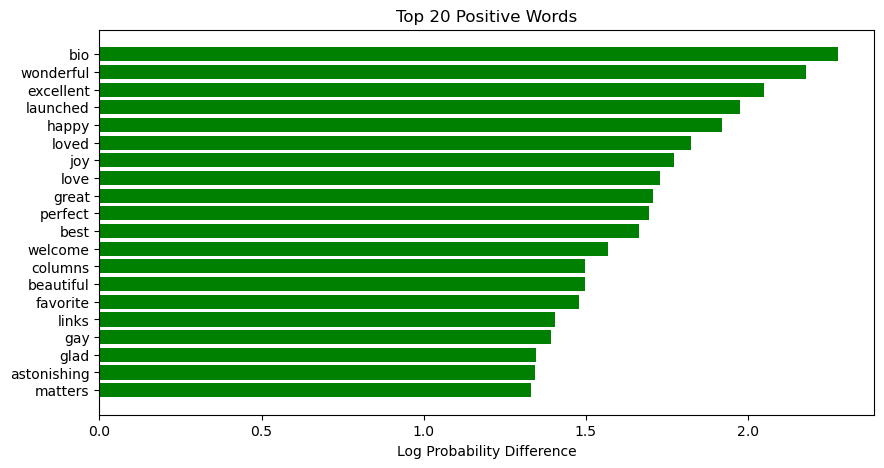

In [23]:
plt.figure(figsize=(10, 5))
plt.barh([feature_names[i] for i in top_positive_indices], feature_prob[top_positive_indices], color='green')
plt.xlabel('Log Probability Difference')
plt.title('Top 20 Positive Words')
plt.gca().invert_yaxis()
plt.savefig('C:/Users/user/Desktop/SALFORD 2/positive top 20 words.png')
plt.show()

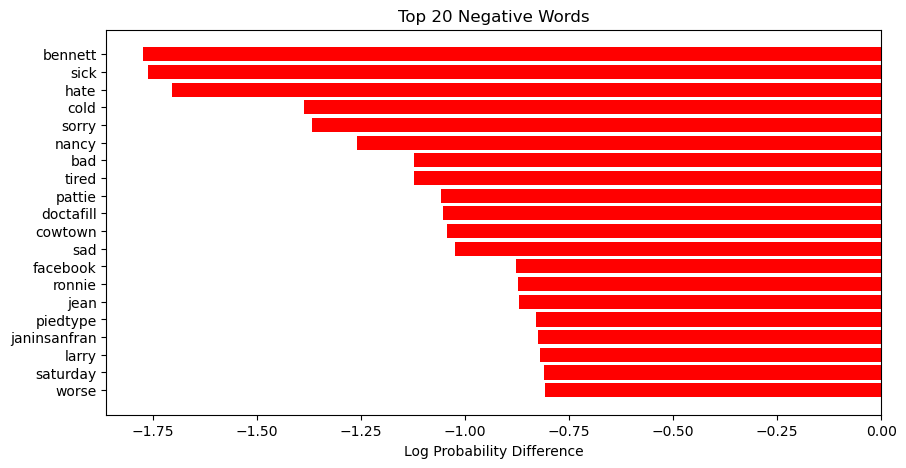

In [24]:
plt.figure(figsize=(10, 5))
plt.barh([feature_names[i] for i in top_negative_indices], feature_prob[top_negative_indices], color='red')
plt.xlabel('Log Probability Difference')
plt.title('Top 20 Negative Words')
plt.gca().invert_yaxis()
plt.savefig('C:/Users/user/Desktop/SALFORD 2/negative top 20 words.png')
plt.show()


# Sentiment Distribution by Class

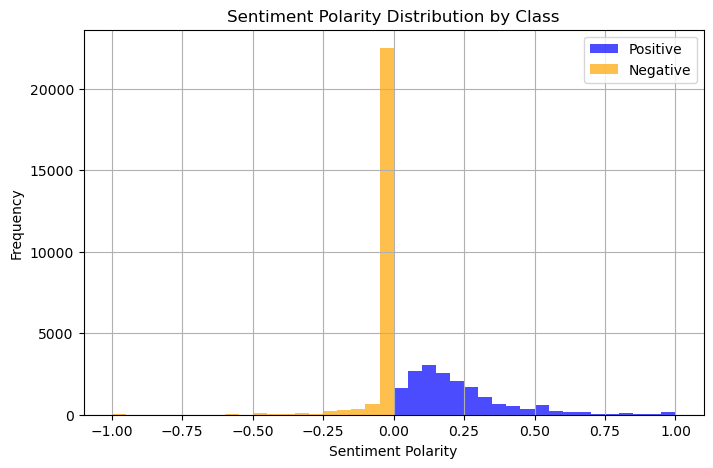

In [25]:
plt.figure(figsize=(8, 5))
blogpost[blogpost['label'] == 1]['sentiment'].hist(bins=20, alpha=0.7, color='blue', label='Positive')
blogpost[blogpost['label'] == 0]['sentiment'].hist(bins=20, alpha=0.7, color='orange', label='Negative')
plt.title("Sentiment Polarity Distribution by Class")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.legend()
plt.savefig('C:/Users/user/Desktop/SALFORD 2/sentiment polarity distribution.png')
plt.show()

# Roc curve

In [26]:
# Computing ROC curve and AUC
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

In [27]:
roc_auc

0.7609726278405261

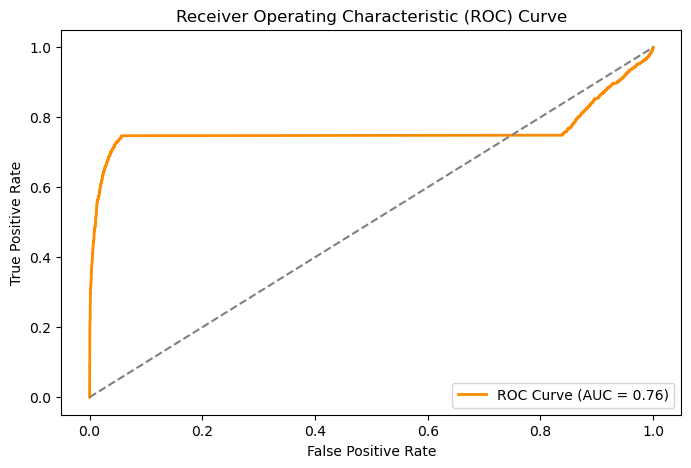

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig('C:/Users/user/Desktop/SALFORD 2/roc curve.png')
plt.show()


# WordCloud by class

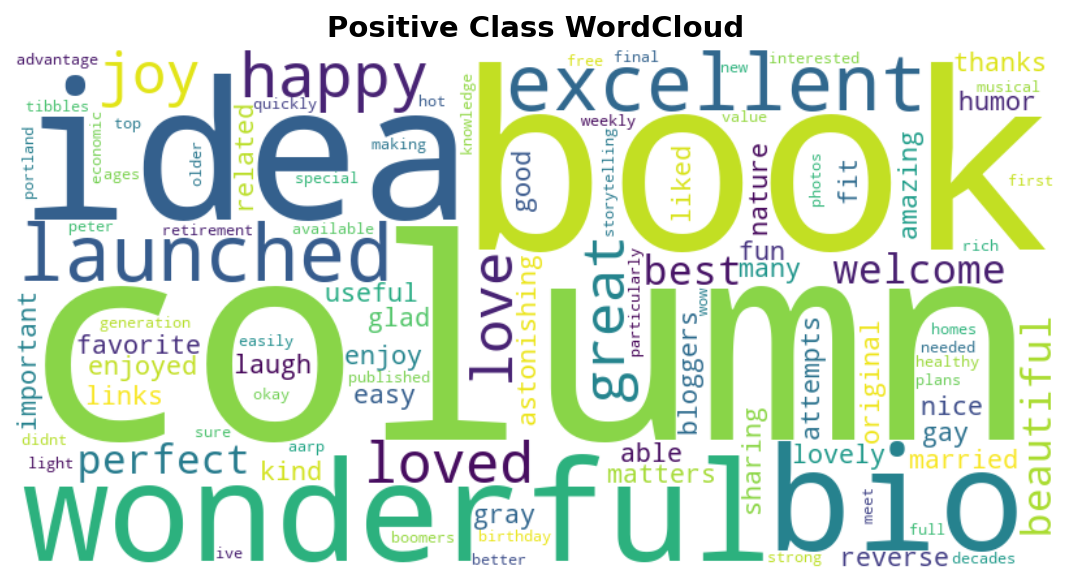

In [29]:
feature_names = vectorizer.get_feature_names_out()

# Positive and Negative Indices for the top 100 words
positive_indices = feature_prob.argsort()[-100:][::-1]
negative_indices = feature_prob.argsort()[:100]

positive_words = [feature_names[i] for i in positive_indices]

# A text string of the top 100 positive words (for WordCloud)
positive_text = " ".join(positive_words)

# Generating the WordCloud for Positive Class
positive_wc = WordCloud(
    stopwords=set(stopwords.words('english')),
    background_color='white',
    max_words=100,
    width=800,
    height=400
).generate(positive_text)

# Visualizing Positive Class WordCloud
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Class WordCloud', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/SALFORD 2/positive word cloud.png')
plt.show()


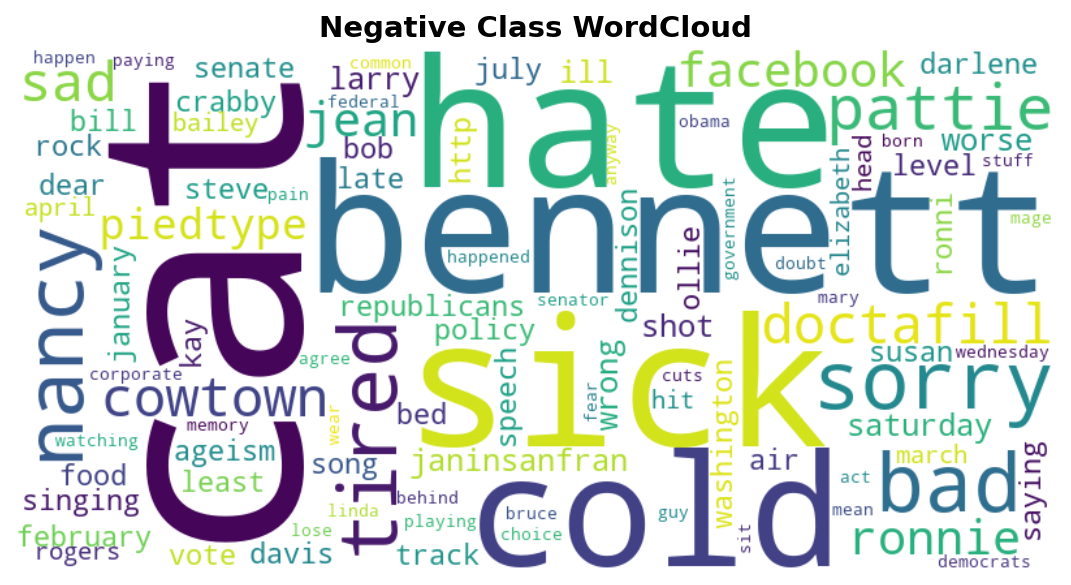

In [30]:
negative_words = [feature_names[i] for i in negative_indices]

negative_text = " ".join(negative_words)

negative_wc = WordCloud(
    stopwords=set(stopwords.words('english')),
    background_color='white',
    max_words=100,
    width=800,
    height=400
).generate(negative_text)

# Visualizing Negative Class WordCloud
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Class WordCloud', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/SALFORD 2/negative word cloud.png')
plt.show()
